extension of the original paper: https://arxiv.org/pdf/1606.06996.pdf

Observation: Not all entropy estimators are created equal - the above paper showed that different estimators that have similar convergence properties and are highly correlated on the data - but it turns out that this does not mean that all these estimators will be related to translation accuracy. In particular, it appears that histogram / frequency approaches with strong iid assumptions are most correlated with translation performance. 

To me, this suggests (a) that the *uncertainty* measured by an entropy estimator can be attributed to multiple factors, (b) that different estimators (although equal in limit under strong assumptions) are affected differently by these factors, and that (c) identifying which ones are related to *translatability* helps us understand specific models and machine translation in general.

Specifically: 
    - data: europarl, BLEU scores from models trained on this
    - model: entropy estimator
    - output: entropy (used to get entropy ratio to calc translation score
    - metric: use correlation strength to compare estimators on a model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Entropy Rate Estimators and Translation Probability
***********

In [2]:
# translation data
# https://aclanthology.org/2005.mtsummit-papers.11.pdf

# ['Danish','German','Greek','English','Spanish','French','Finnish','Italian','Dutch','Portugese','Swedish']
languages = 'da de el en es fr fi it nl pt sv'
bleu_data = \
'''- 18.4 21.1 28.5 26.4 28.7 14.2 22.2 21.4 24.3 28.3
22.3 - 20.7 25.3 25.4 27.7 11.8 21.3 23.4 23.2 20.5
22.7 17.4 - 27.2 31.2 32.1 11.4 26.8 20.0 27.6 21.2
25.2 17.6 23.2 - 30.1 31.1 13.0 25.3 21.0 27.1 24.8
24.1 18.2 28.3 30.5 - 40.2 12.5 32.3 21.4 35.9 23.9
23.7 18.5 26.1 30.0 38.4 - 12.6 32.4 21.1 35.3 22.6
20.0 14.5 18.2 21.8 21.1 22.4 - 18.3 17.0 19.1 18.8
21.4 16.9 24.8 27.8 34.0 36.0 11.0 - 20.0 31.2 20.2
20.5 18.3 17.4 23.0 22.9 24.6 10.3 20.0 - 20.7 19.0
23.2 18.2 26.4 30.1 37.9 39.0 11.9 32.0 20.2 - 21.9
30.3 18.9 22.8 30.2 28.6 29.7 15.3 23.9 21.9 25.9 -'''

df_bleu = pd.DataFrame([r.split(' ') for r in bleu_data.split('\n')], dtype=float, columns=languages.split(' '), index=languages.split(' '))
df_bleu

,da,de,el,en,es,fr,fi,it,nl,pt,sv
da,-,18.4,21.1,28.5,26.4,28.7,14.2,22.2,21.4,24.3,28.3
de,22.3,-,20.7,25.3,25.4,27.7,11.8,21.3,23.4,23.2,20.5
el,22.7,17.4,-,27.2,31.2,32.1,11.4,26.8,20.0,27.6,21.2
en,25.2,17.6,23.2,-,30.1,31.1,13.0,25.3,21.0,27.1,24.8
es,24.1,18.2,28.3,30.5,-,40.2,12.5,32.3,21.4,35.9,23.9
fr,23.7,18.5,26.1,30.0,38.4,-,12.6,32.4,21.1,35.3,22.6
fi,20.0,14.5,18.2,21.8,21.1,22.4,-,18.3,17.0,19.1,18.8
it,21.4,16.9,24.8,27.8,34.0,36.0,11.0,-,20.0,31.2,20.2
nl,20.5,18.3,17.4,23.0,22.9,24.6,10.3,20.0,-,20.7,19.0
pt,23.2,18.2,26.4,30.1,37.9,39.0,11.9,32.0,20.2,-,21.9


In [3]:
# europarl data
# https://www.statmt.org/europarl/archives.html
import re
from os import listdir
from os.path import isfile, join

def filenames(lang):
    base_path = f"europarl/txt/{lang}/"
    files = [base_path+f for f in listdir(base_path) if isfile(join(base_path, f))]
    files = sorted(files)
    return files

def get_sentences(path):
    with open(path, 'r') as f:
        data = f.read()
    
    data = re.sub('<[^<]+?>', '', data) # remove tags
    
    data = re.sub('[0-9/!?]', '.', data) # end of sentence
    data = re.sub('[0-9/\-\(\):,"]', '', data) # no special chars
    data = data.lower().split('.')
    return [s.split() for s in data]

def get_file(path):
    data = []
    for s in get_sentences(path):
        data += s
    return data

def sample_txt(lang): 
    files = filenames(lang)
    return get_file(files[np.random.randint(len(files))])

def all_sentences(lang):
    files = filenames(lang)
    data = []
    for f in files:
        data += get_sentences(f)
    return data

def all_txt(lang):
    files = filenames(lang)
    data = []
    for f in files:
        data += get_file(f)
    return data
    
len(sample_txt('en'))

5565

In [6]:
# nsb entropy (iid)
# https://gist.github.com/shhong/1021654
import nsb_entropy as nsb

def nsb_entropy(lang,
                n_words=1000,
                ):
    # build histogram
    corp = all_txt(lang)[:n_words]
    vocab = {w:i for i,w in enumerate(set(corp))}
    
    hist = np.zeros(len(vocab))
    for w in corp: # words
        hist[vocab[w]] += 1

    nxkx = nsb.make_nxkx(hist, len(hist))
    H = nsb.S(nxkx, hist.sum(), len(nxkx))
    return H
    
nsb_entropy('en')

56.90270873565933798515510918042136167824

In [5]:
# source entropy (iid)
# https://www.dam.brown.edu/people/elie/papers/Gao%20Kontoyiannis%20Bienenstock%20Estimating%20the%20entropy%20of%20binary%20time%20series.pdf
def lz_entropy(lang,
               n_words=1000,
               window_size=10,
               ):
    assert window_size < n_words
    
    corp = all_txt(lang)[:n_words]
    
    ls = 0
    for i in range(len(corp)): # for each position
        l = 1
        for j in range(i-window_size, i): # sliding window
            lj = 0
            while lj<window_size and corp[(i+lj)%len(corp)]==corp[(j+lj)%len(corp)]: 
                lj += 1
            l = max(l, lj)
        ls += (np.log(window_size) / np.log(2)) / l
    H = ls / (len(corp))
    return H

lz_entropy('en')

3.2902036815812243

In [10]:
# recreate paper results
# https://arxiv.org/pdf/1606.06996.pdf
lang_src = {}
for lang in languages.split():
    lang_src[lang] = lz_entropy(lang, n_words=100000, window_size=1000)

paper : r= 0.58
ours  : r= 0.3028437799602216


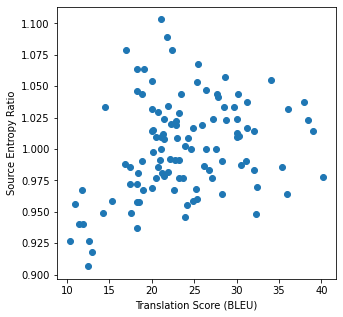

In [11]:
bleu = []
src_r = []
for l1 in languages.split():
    for l2 in languages.split():
        if l1 != l2:
            bleu.append(float(df_bleu[l1][l2]))
            src_r.append(float(lang_src[l2]/lang_src[l1]))
            
print('paper : r= 0.58')
print(f'ours  : r=',np.corrcoef(bleu, src_r)[0,1])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(bleu, src_r)
ax.set_xlabel('Translation Score (BLEU)')
ax.set_ylabel('Source Entropy Ratio')
plt.show()

In [12]:
# try with nsb estimator
lang_nsb = {}
for lang in languages.split():
    lang_nsb[lang] = nsb_entropy(lang, n_words=100000)

bleu, source  : r= 0.3028437799602216
bleu, nsb     : r= 0.1197372466509679
source, nsb   : r= 0.8218469469670985


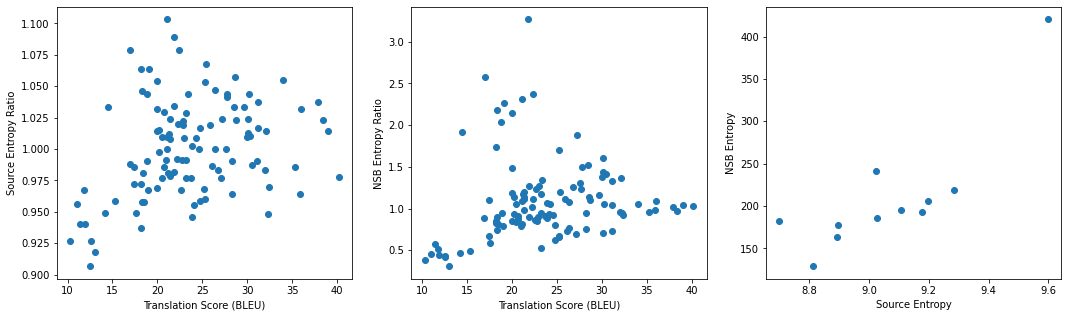

In [13]:
nsb_r = []
for l1 in languages.split():
    for l2 in languages.split():
        if l1 != l2:
            nsb_r.append(float(lang_nsb[l2]/lang_nsb[l1]))

            
print('bleu, source  : r=',np.corrcoef(bleu, src_r)[0,1])
print('bleu, nsb     : r=',np.corrcoef(bleu, nsb_r)[0,1])
l1, l2 = [float(lang_src[l]) for l in languages.split()], [float(lang_nsb[l]) for l in languages.split()]
print('source, nsb   : r=',np.corrcoef(l1, l2)[0,1])
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18,5))

ax1.scatter(bleu, src_r)
ax1.set_xlabel('Translation Score (BLEU)')
ax1.set_ylabel('Source Entropy Ratio')

ax2.scatter(bleu, nsb_r)
ax2.set_xlabel('Translation Score (BLEU)')
ax2.set_ylabel('NSB Entropy Ratio')

ax3.scatter(l1, l2)
ax3.set_xlabel('Source Entropy')
ax3.set_ylabel('NSB Entropy')

plt.show()

In [14]:
# word embeddings
# https://radimrehurek.com/gensim/models/word2vec.html
from gensim.models import Word2Vec

def train_w2v(lang,
              num_sentences=10000,
              vec_size=10,
              epochs=5,
              min_count=5,
              ):
    sentences = all_sentences(lang)[:num_sentences]
    w2v = Word2Vec(vector_size=vec_size, window=5, min_count=4)
    w2v.build_vocab(sentences)  # prepare the model vocabulary
    w2v.train(sentences, total_examples=len(sentences), epochs=epochs)  # train word vectors
    w2v.save(f"europarl/w2v/{lang}.model")
    return w2v

def load_w2v(lang):
    return Word2Vec.load(f"europarl/w2v/{lang}.model")

# train wvs for each language
# lang_wv = {}
# for lang in languages.split():
#     print(lang)
#     lang_wv[lang] = train_w2v(lang)

In [15]:
lang_wv = {l:load_w2v(l) for l in languages.split()}

In [21]:
# semantic heat
def semantic_heat(lang,
                  n_blocks=1000,
                  block_size=1,
                  m=0,
                  ):
    assert 0<=m and m<1
    
    w2v = lang_wv[lang]
    corp = all_txt(lang)[:n_blocks*block_size]
    
    D = []
    p, v, nv = None, None, []
    for i in range(1,len(corp), block_size):
        if corp[i] not in w2v.wv:
            continue
        nv.append(np.copy(w2v.wv[corp[i]]))
        if len(nv)==block_size:
            vv = sum(nv)
            nv = []
            if p is None:
                p = vv
                v = np.zeros_like(p)
            else:
                v = m*v + (1-m)*(vv-p)
                D.append(np.linalg.norm(v))
                p += v
    D = np.array(D)
    return D.mean(), D.std()
        
# try with heat
lang_heat_0 = {}
for lang in languages.split():
    lang_heat_0[lang] = semantic_heat(lang, n_blocks=100000, m=0)
        
lang_heat_5 = {}
for lang in languages.split():
    lang_heat_5[lang] = semantic_heat(lang, n_blocks=100000, m=0.5)
    
lang_heat_long = {}
for lang in languages.split():
    lang_heat_long[lang] = semantic_heat(lang, n_blocks=10000, m=0, block_size=10)

source, heat (m=0)       : r= -0.5911229261998613
source, heat (m=0) (var) : r= 0.35942696345238423
source, heat (m=0.5)       : r= -0.5585796467491416
source, heat (m=0.5) (var) : r= -0.014955413438696878
source, heat long (m=0)       : r= -0.6244047770153276
source, heat long (m=0) (var) : r= 0.2860630570329471
nsb, heat (m=0)       : r= -0.33351556166910057
nsb, heat (m=0) (var) : r= 0.6499935820906156
nsb, heat (m=0.5)       : r= -0.2830954654157854
nsb, heat (m=0.5) (var) : r= 0.30169220855485357
nsb, heat long (m=0)       : r= -0.3947655932799011
nsb, heat long (m=0) (var) : r= 0.6038911658632863


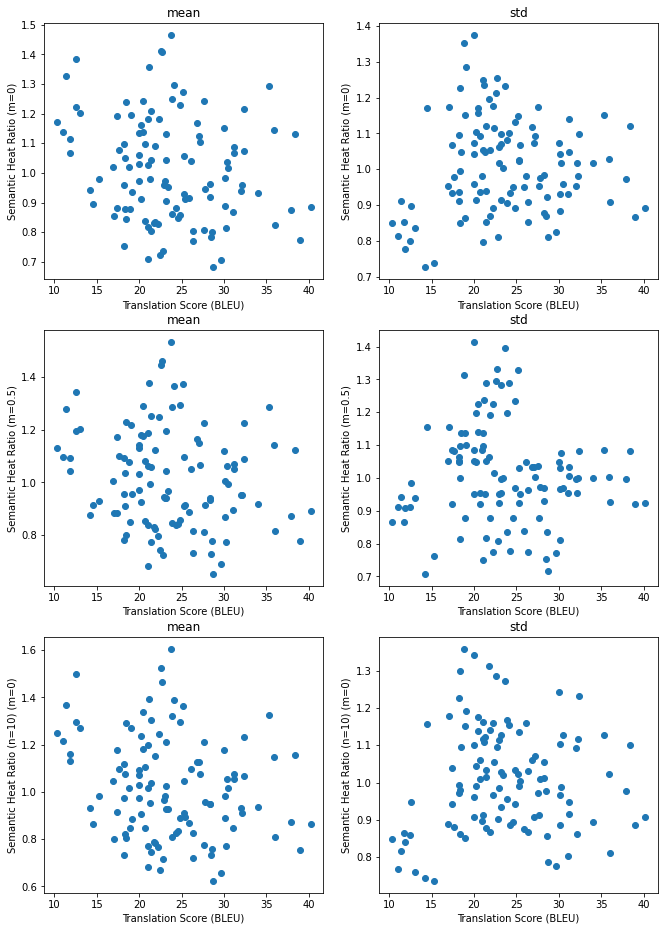

In [25]:
h0_r, h5_r, h0s_r, h5s_r, hl_r, hls_r = [], [], [], [], [], []
for l1 in languages.split():
    for l2 in languages.split():
        if l1 != l2:
            h0_r.append(float(lang_heat_0[l2][0]/lang_heat_0[l1][0]))
            h5_r.append(float(lang_heat_5[l2][0]/lang_heat_5[l1][0]))
            hl_r.append(float(lang_heat_long[l2][0]/lang_heat_long[l1][0]))
            h0s_r.append(float(lang_heat_0[l2][1]/lang_heat_0[l1][1]))
            h5s_r.append(float(lang_heat_5[l2][1]/lang_heat_5[l1][1]))
            hls_r.append(float(lang_heat_long[l2][1]/lang_heat_long[l1][1]))
            
x = [('source',lang_src),('nsb',lang_nsb),]
y = [('heat (m=0)',lang_heat_0),('heat (m=0.5)',lang_heat_5), ('heat long (m=0)',lang_heat_long)]
for na,a in x:
    for nb,b in y:
        l1, l2, l3 = [float(a[l]) for l in languages.split()], [float(b[l][0]) for l in languages.split()], [float(b[l][1]) for l in languages.split()]
        print(f'{na}, {nb}       : r=',np.corrcoef(l1, l2)[0,1])
        print(f'{na}, {nb} (var) : r=',np.corrcoef(l1, l3)[0,1])
            
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(11,16))

ax1.scatter(bleu, h0_r)
ax1.set_title('mean')
ax1.set_xlabel('Translation Score (BLEU)')
ax1.set_ylabel('Semantic Heat Ratio (m=0)')

ax2.scatter(bleu, h0s_r)
ax2.set_title('std')
ax2.set_xlabel('Translation Score (BLEU)')
ax2.set_ylabel('Semantic Heat Ratio (m=0)')

ax3.scatter(bleu, h5_r)
ax3.set_title('mean')
ax3.set_xlabel('Translation Score (BLEU)')
ax3.set_ylabel('Semantic Heat Ratio (m=0.5)')

ax4.scatter(bleu, h5s_r)
ax4.set_title('std')
ax4.set_xlabel('Translation Score (BLEU)')
ax4.set_ylabel('Semantic Heat Ratio (m=0.5)')

ax5.scatter(bleu, hl_r)
ax5.set_title('mean')
ax5.set_xlabel('Translation Score (BLEU)')
ax5.set_ylabel('Semantic Heat Ratio (n=10) (m=0)')

ax6.scatter(bleu, hls_r)
ax6.set_title('std')
ax6.set_xlabel('Translation Score (BLEU)')
ax6.set_ylabel('Semantic Heat Ratio (n=10) (m=0)')

plt.show()

histogram estimation (only use word frequency)

In [30]:
from collections import defaultdict

# histogram entropy
def histogram_ent(lang, n_words=10000):
    corp = all_txt(lang)[:n_words]
    D = defaultdict(lambda: 0)
    for w in corp:
        D[w] += 1
    return sum([-D[w] * np.log(D[w]/n_words) for w in D]) / n_words
        
#
lang_hh = {}
for lang in languages.split():
    lang_hh[lang] = histogram_ent(lang, n_words=10000)

paper : r= 0.58
ours  : r= 0.24030938832332524


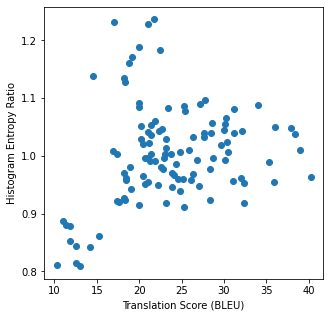

In [37]:
hst_r = []
for l1 in languages.split():
    for l2 in languages.split():
        if l1 != l2:
            hst_r.append(float(lang_hh[l2]/lang_hh[l1]))
            
print('paper : r= 0.58')
print(f'ours  : r=',np.corrcoef(bleu, hst_r)[0,1])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(bleu, hst_r)
ax.set_xlabel('Translation Score (BLEU)')
ax.set_ylabel('Histogram Entropy Ratio')
plt.show()